In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.base import BaseEstimator, ClassifierMixin
import xgboost as xgb
import joblib
import logging

# If you're using matplotlib for visualizations, uncomment the following line:
# import matplotlib.pyplot as plt

class XGBoostClassifierWithEarlyStopping(BaseEstimator, ClassifierMixin):
    def __init__(self, early_stopping_rounds=10, **kwargs):
        self.early_stopping_rounds = early_stopping_rounds
        self.params = kwargs
        self.model = None
        self.best_iteration = None

    def fit(self, X, y):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        self.model = xgb.XGBClassifier(**self.params)
        
        # Train the model with manual early stopping
        self.model.fit(X_train, y_train)
        
        best_score = float('inf')
        best_iteration = 0
        for i in range(self.model.n_estimators):
            self.model.n_estimators = i + 1
            y_pred = self.model.predict_proba(X_val)
            score = log_loss(y_val, y_pred)
            if score < best_score:
                best_score = score
                best_iteration = i
            elif i - best_iteration >= self.early_stopping_rounds:
                break
        
        # Retrain the model with the best number of iterations
        self.best_iteration = best_iteration + 1
        self.model.n_estimators = self.best_iteration
        self.model.fit(X, y)
        
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

    def get_params(self, deep=True):
        return {**super().get_params(deep), **self.params, 'early_stopping_rounds': self.early_stopping_rounds}

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        if 'early_stopping_rounds' in params:
            self.early_stopping_rounds = params['early_stopping_rounds']
        else:
            self.params.update(params)
        return self

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load data
df = pd.read_csv(r'C:\Users\14807\OneDrive\Spreadsheets\Data Science Capstone\AI_ML_Biotech\Data Collection\Final Data Merging after Collection\merged_alzheimers_data.csv')

# Create binary target variable
df['is_alzheimers'] = df['MAPPED_TRAIT'].str.contains('Alzheimer', case=False, na=False).astype(int)

# Select relevant features
features = ['STRONGEST SNP-RISK ALLELE', 'P-VALUE', 'OR or BETA', 'RISK ALLELE FREQUENCY', 'PVALUE_MLOG']
X = df[features].copy()
y = df['is_alzheimers']

# Handle 'NR' in 'RISK ALLELE FREQUENCY'
X['RISK ALLELE FREQUENCY'] = X['RISK ALLELE FREQUENCY'].replace('NR', np.nan)

# Define numeric and categorical columns
numeric_features = ['P-VALUE', 'OR or BETA', 'PVALUE_MLOG']
categorical_features = ['STRONGEST SNP-RISK ALLELE']
special_numeric = ['RISK ALLELE FREQUENCY']

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features),
        ('special_num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), special_numeric)
    ])

# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBoostClassifierWithEarlyStopping(
        use_label_encoder=False,
        random_state=42
    ))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = dict(zip(np.unique(y), len(y) / (len(np.unique(y)) * np.bincount(y))))

# Define expanded hyperparameter space
param_dist = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],
    'classifier__min_child_weight': [1, 3, 5],
    'classifier__reg_alpha': [0.1, 0.5, 1],
    'classifier__reg_lambda': [0.1, 0.5, 1],
    'classifier__gamma': [0, 0.1, 0.2],
    'classifier__scale_pos_weight': [class_weights[1] / class_weights[0]],
    'classifier__early_stopping_rounds': [5, 10, 20]
}
# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_dist, 
    n_iter=50,
    cv=5,
    random_state=42,
    n_jobs=-1,
    scoring='roc_auc'  # Specify a scoring metric
)

# Fit the model
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
logging.info(f"Best hyperparameters: {random_search.best_params_}")

# Evaluate the model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba)}")

# Function to predict risk for new data
def predict_alzheimers_risk(new_data):
    try:
        # Make prediction
        risk_probability = best_model.predict_proba(new_data)[0][1]  # Probability of class 1 (Alzheimer's)
        return risk_probability * 100  # Convert to percentage
    except Exception as e:
        logging.error(f"Error in prediction: {str(e)}")
        return None

# Save the model
joblib.dump(best_model, 'alzheimers_risk_model.joblib')

# Example usage
new_person = pd.DataFrame({
    'STRONGEST SNP-RISK ALLELE': ['rs429358-C'],
    'P-VALUE': [1e-200],
    'OR or BETA': [3.685],
    'RISK ALLELE FREQUENCY': [0.15],
    'PVALUE_MLOG': [200]
}, index=[0])

risk = predict_alzheimers_risk(new_person)
if risk is not None:
    print(f"\nPredicted Alzheimer's risk: {risk:.2f}%")
else:
    print("Unable to predict risk due to an error.")

# ML Model Step By Step

In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import joblib
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [2]:
# Cell 2: Load Data and Preprocess
df = pd.read_csv(r'C:\Users\14807\OneDrive\Spreadsheets\Data Science Capstone\AI_ML_Biotech\Data Collection\Final Data Merging after Collection\merged_alzheimers_data.csv')

df['is_alzheimers'] = df['MAPPED_TRAIT'].str.contains('Alzheimer', case=False, na=False).astype(int)

features = ['STRONGEST SNP-RISK ALLELE', 'P-VALUE', 'OR or BETA', 'RISK ALLELE FREQUENCY', 'PVALUE_MLOG']
X = df[features].copy()
y = df['is_alzheimers']

X['RISK ALLELE FREQUENCY'] = X['RISK ALLELE FREQUENCY'].replace('NR', np.nan)

numeric_features = ['P-VALUE', 'OR or BETA', 'PVALUE_MLOG']
categorical_features = ['STRONGEST SNP-RISK ALLELE']
special_numeric = ['RISK ALLELE FREQUENCY']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features),
        ('special_num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), special_numeric)
    ])


In [3]:
# Cell 3: Define Model Pipeline and Hyperparameters
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        random_state=42,
        class_weight='balanced'
    ))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_dist = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}


In [4]:
# Cell 4: Hyperparameter Tuning and Model Fitting (Simplified)
# Use a smaller subset of data for quicker hyperparameter tuning
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=0.1, random_state=42)

# Simplify the hyperparameter space
param_dist = {
    'classifier__n_estimators': [50, 100],  # Reduced number of trees
    'classifier__max_depth': [5, 10],       # Smaller tree depths
    'classifier__min_samples_split': [2, 4],  # Simplified splits
    'classifier__min_samples_leaf': [1, 2]
}

# Reduce cross-validation folds to 2 for faster tuning
random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_dist, 
    n_iter=5,  # Reduced iterations
    cv=2,  # Reduced number of folds
    random_state=42,
    n_jobs=-1,
    scoring='roc_auc'
)

# Fit the model on the sampled data
random_search.fit(X_train_sample, y_train_sample)

# Retrieve the best model
best_model = random_search.best_estimator_
logging.info(f"Best hyperparameters: {random_search.best_params_}")


2024-08-13 01:00:44,403 - INFO - Best hyperparameters: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 10}


In [5]:
# Cell 5: Model Evaluation and Persistence
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

# Save the trained model
joblib.dump(best_model, 'alzheimers_risk_model.joblib')



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     13429
           1       0.21      0.93      0.34       517

    accuracy                           0.87     13946
   macro avg       0.60      0.90      0.64     13946
weighted avg       0.97      0.87      0.91     13946


Confusion Matrix:
[[11639  1790]
 [   38   479]]

ROC-AUC Score: 0.9545


['alzheimers_risk_model.joblib']

In [7]:
# Feature Importance
feature_importance = best_model.named_steps['classifier'].feature_importances_

# Get feature names for one-hot encoded categorical features
onehot_encoder = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = onehot_encoder.get_feature_names_out(categorical_features).tolist()

# Combine all feature names
feature_names = cat_feature_names + numeric_features + special_numeric

importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False).head(10)
print("\nTop 10 Important Features:")
print(importance_df)

# Threshold Tuning
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
optimal_threshold = thresholds[np.argmax(f1_scores[:-1])]  # Exclude the last element as it's always 1
print(f"\nOptimal Threshold: {optimal_threshold:.4f}")

# Evaluate with optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal))


Top 10 Important Features:
                                               feature  importance
0              STRONGEST SNP-RISK ALLELE_9:107541903-T    0.211260
1          STRONGEST SNP-RISK ALLELE_chr10:125081474-C    0.173791
2          STRONGEST SNP-RISK ALLELE_chr10:135344579-G    0.138925
654                              RISK ALLELE FREQUENCY    0.119635
57          STRONGEST SNP-RISK ALLELE_chr2:242393574-A    0.083728
371  STRONGEST SNP-RISK ALLELE_rs2617921-? x rs1023...    0.069670
40          STRONGEST SNP-RISK ALLELE_chr1:219365421-T    0.010111
457               STRONGEST SNP-RISK ALLELE_rs527162-?    0.009330
103           STRONGEST SNP-RISK ALLELE_chr8:3743232-C    0.008771
98           STRONGEST SNP-RISK ALLELE_chr7:43397700-T    0.008745

Optimal Threshold: 0.7350

Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     13429
           1       1.00      0.49      0.66       51

### Model using Random Forest


Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       180
           1       0.00      0.00      0.00        20

    accuracy                           0.90       200
   macro avg       0.45      0.50      0.47       200
weighted avg       0.81      0.90      0.85       200


ROC-AUC Score: 0.5264

Optimal Threshold: 0.3903

Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       180
           1       0.00      0.00      0.00        20

    accuracy                           0.89       200
   macro avg       0.45      0.49      0.47       200
weighted avg       0.81      0.89      0.85       200



C:\Users\14807\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\14807\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\14807\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\14807\AppData\Local\Temp\ipyker

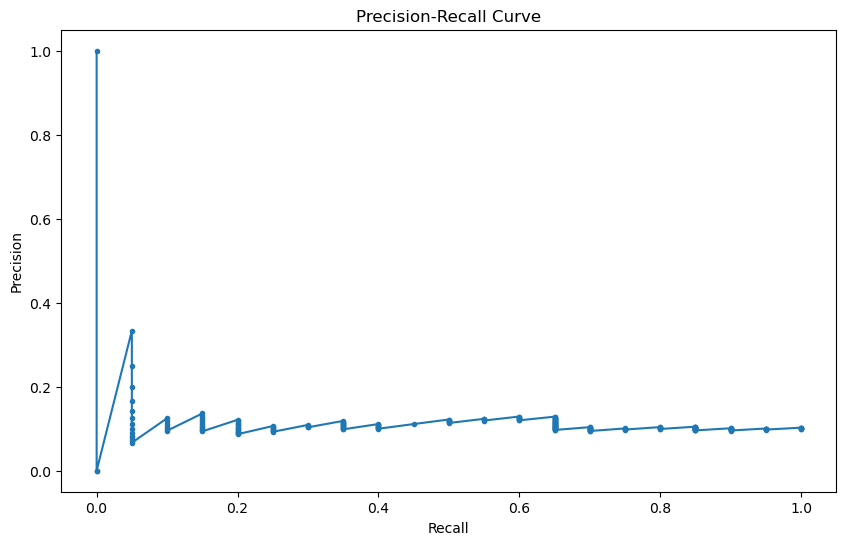


Top 5 Important Features:
                         feature  importance
1  STRONGEST SNP-RISK ALLELE_C-G    0.260623
7          RISK ALLELE FREQUENCY    0.239900
0  STRONGEST SNP-RISK ALLELE_A-T    0.229082
2  STRONGEST SNP-RISK ALLELE_G-C    0.205597
3  STRONGEST SNP-RISK ALLELE_T-A    0.019297


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt

class ImprovedAlzheimersRiskModel:
    def __init__(self):
        self.model = None
        self.features = ['STRONGEST SNP-RISK ALLELE', 'P-VALUE', 'OR or BETA', 'RISK ALLELE FREQUENCY', 'PVALUE_MLOG']
        self.numeric_features = ['P-VALUE', 'OR or BETA', 'PVALUE_MLOG']
        self.categorical_features = ['STRONGEST SNP-RISK ALLELE']
        self.special_numeric = ['RISK ALLELE FREQUENCY']

    def preprocess_data(self):
        return ColumnTransformer(
            transformers=[
                ('num', Pipeline([
                    ('imputer', SimpleImputer(strategy='mean')),
                    ('scaler', StandardScaler())
                ]), self.numeric_features),
                ('cat', Pipeline([
                    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
                ]), self.categorical_features),
                ('special_num', Pipeline([
                    ('imputer', SimpleImputer(strategy='mean')),
                    ('scaler', StandardScaler())
                ]), self.special_numeric)
            ])

    def train(self, X, y):
        X = X[self.features]
        X['RISK ALLELE FREQUENCY'] = X['RISK ALLELE FREQUENCY'].replace('NR', np.nan)

        preprocessor = self.preprocess_data()

        # Calculate class weights
        class_weights = {0: 1, 1: len(y) / sum(y) / 2}  # Adjust weight for minority class

        self.model = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(
                n_estimators=100,
                max_depth=10,
                min_samples_split=2,
                min_samples_leaf=2,
                random_state=42,
                class_weight=class_weights
            ))
        ])

        self.model.fit(X, y)

    def predict(self, X):
        X = X[self.features]
        X['RISK ALLELE FREQUENCY'] = X['RISK ALLELE FREQUENCY'].replace('NR', np.nan)
        return self.model.predict(X)

    def predict_proba(self, X):
        X = X[self.features]
        X['RISK ALLELE FREQUENCY'] = X['RISK ALLELE FREQUENCY'].replace('NR', np.nan)
        return self.model.predict_proba(X)[:, 1]

    def evaluate(self, X, y):
        y_pred = self.predict(X)
        y_pred_proba = self.predict_proba(X)

        print("\nClassification Report:")
        print(classification_report(y, y_pred))
        print(f"\nROC-AUC Score: {roc_auc_score(y, y_pred_proba):.4f}")

    def find_optimal_threshold(self, X, y):
        y_pred_proba = self.predict_proba(X)
        precisions, recalls, thresholds = precision_recall_curve(y, y_pred_proba)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
        optimal_threshold = thresholds[np.argmax(f1_scores[:-1])]  # Exclude last element as it's always 1
        return optimal_threshold

    def predict_with_threshold(self, X, threshold):
        return (self.predict_proba(X) >= threshold).astype(int)

    def plot_precision_recall_curve(self, X, y):
        y_pred_proba = self.predict_proba(X)
        precisions, recalls, _ = precision_recall_curve(y, y_pred_proba)
        
        plt.figure(figsize=(10, 6))
        plt.plot(recalls, precisions, marker='.')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.show()

    def get_feature_importance(self):
        feature_importance = self.model.named_steps['classifier'].feature_importances_
        preprocessor = self.model.named_steps['preprocessor']
        onehot_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
        cat_feature_names = onehot_encoder.get_feature_names_out(self.categorical_features).tolist()
        feature_names = cat_feature_names + self.numeric_features + self.special_numeric
        importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
        return importance_df.sort_values('importance', ascending=False)

# Usage
if __name__ == "__main__":
    # Generate sample data
    np.random.seed(42)
    n_samples = 1000
    sample_data = pd.DataFrame({
        'STRONGEST SNP-RISK ALLELE': np.random.choice(['A-T', 'C-G', 'T-A', 'G-C'], n_samples),
        'P-VALUE': np.random.uniform(0, 1, n_samples),
        'OR or BETA': np.random.normal(1, 0.5, n_samples),
        'RISK ALLELE FREQUENCY': np.random.uniform(0, 1, n_samples),
        'PVALUE_MLOG': np.random.uniform(0, 10, n_samples),
        'is_alzheimers': np.random.choice([0, 1], n_samples, p=[0.9, 0.1])  # 10% Alzheimer's cases
    })

    # Split the data
    X = sample_data.drop('is_alzheimers', axis=1)
    y = sample_data['is_alzheimers']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the improved model
    model = ImprovedAlzheimersRiskModel()
    model.train(X_train, y_train)

    # Evaluate the model
    model.evaluate(X_test, y_test)

    # Find optimal threshold
    optimal_threshold = model.find_optimal_threshold(X_test, y_test)
    print(f"\nOptimal Threshold: {optimal_threshold:.4f}")

    # Evaluate with optimal threshold
    y_pred_optimal = model.predict_with_threshold(X_test, optimal_threshold)
    print("\nClassification Report with Optimal Threshold:")
    print(classification_report(y_test, y_pred_optimal))

    # Plot Precision-Recall curve
    model.plot_precision_recall_curve(X_test, y_test)

    # Get feature importance
    importance_df = model.get_feature_importance()
    print("\nTop 5 Important Features:")
    print(importance_df.head())

# Model using XGBoost

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
import joblib
import logging
import os

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [16]:
# Load data
df = pd.read_csv(r'C:\Users\14807\OneDrive\Spreadsheets\Data Science Capstone\AI_ML_Biotech\Data Collection\Final Data Merging after Collection\merged_alzheimers_data.csv')

# Create binary target variable
df['is_alzheimers'] = df['MAPPED_TRAIT'].str.contains('Alzheimer', case=False, na=False).astype(int)

# Select relevant features
features = ['STRONGEST SNP-RISK ALLELE', 'P-VALUE', 'OR or BETA', 'RISK ALLELE FREQUENCY', 'PVALUE_MLOG']
X = df[features].copy()
y = df['is_alzheimers']

# Handle 'NR' in 'RISK ALLELE FREQUENCY'
X.loc[:, 'RISK ALLELE FREQUENCY'] = X['RISK ALLELE FREQUENCY'].replace('NR', np.nan)
X.loc[:, 'RISK ALLELE FREQUENCY'] = pd.to_numeric(X['RISK ALLELE FREQUENCY'], errors='coerce')

# Define numeric and categorical columns
numeric_features = ['P-VALUE', 'OR or BETA', 'PVALUE_MLOG']
categorical_features = ['STRONGEST SNP-RISK ALLELE']
special_numeric = ['RISK ALLELE FREQUENCY']

In [17]:
# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features),
        ('special_num', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
            ('scaler', StandardScaler())
        ]), special_numeric)
    ])

# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(eval_metric='logloss', random_state=42))
])

In [18]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = dict(zip(np.unique(y), len(y) / (len(np.unique(y)) * np.bincount(y))))

# Define hyperparameter space
param_dist = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],
    'classifier__scale_pos_weight': [class_weights[1] / class_weights[0]]
}

In [19]:
# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
logging.info(f"Best hyperparameters: {random_search.best_params_}")

2024-08-13 01:36:12,785 - INFO - Best hyperparameters: {'classifier__subsample': 0.8, 'classifier__scale_pos_weight': 27.116129032258062, 'classifier__n_estimators': 300, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.2, 'classifier__colsample_bytree': 0.9}


In [20]:
# Evaluate the model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba)}")

# Cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='roc_auc')
print(f"\nCross-validation ROC-AUC scores: {cv_scores}")
print(f"Mean ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     13429
           1       0.80      0.99      0.88       517

    accuracy                           0.99     13946
   macro avg       0.90      0.99      0.94     13946
weighted avg       0.99      0.99      0.99     13946


Confusion Matrix:
[[13299   130]
 [    4   513]]

ROC-AUC Score: 0.9983513839459134

Cross-validation ROC-AUC scores: [0.99991493 0.98523759 0.90520851 0.999997   0.99627071]
Mean ROC-AUC: 0.9773 (+/- 0.0729)


In [21]:
# Function to predict risk for new data
def predict_alzheimers_risk(new_data):
    try:
        # Handle 'NR' in 'RISK ALLELE FREQUENCY' for new data
        new_data = new_data.copy()
        new_data.loc[:, 'RISK ALLELE FREQUENCY'] = new_data['RISK ALLELE FREQUENCY'].replace('NR', np.nan)
        new_data.loc[:, 'RISK ALLELE FREQUENCY'] = pd.to_numeric(new_data['RISK ALLELE FREQUENCY'], errors='coerce')
        
        # Make prediction
        risk_probability = best_model.predict_proba(new_data)[0][1]  # Probability of class 1 (Alzheimer's)
        return risk_probability * 100  # Convert to percentage
    except Exception as e:
        logging.error(f"Error in prediction: {str(e)}")
        return None

# Save the model
joblib.dump(best_model, 'alzheimers_risk_model.joblib')

['alzheimers_risk_model.joblib']

In [22]:
# Example usage
new_person = pd.DataFrame({
    'STRONGEST SNP-RISK ALLELE': ['rs429358-C'],
    'P-VALUE': [1e-200],
    'OR or BETA': [3.685],
    'RISK ALLELE FREQUENCY': [0.15],
    'PVALUE_MLOG': [200]
}, index=[0])

risk = predict_alzheimers_risk(new_person)
if risk is not None:
    print(f"\nPredicted Alzheimer's risk: {risk:.2f}%")
else:
    print("Unable to predict risk due to an error.")


Predicted Alzheimer's risk: 7.92%


## Full XGBoost code

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
import joblib
import logging
import os

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load data
df = pd.read_csv(r'C:\Users\14807\OneDrive\Spreadsheets\Data Science Capstone\AI_ML_Biotech\Data Collection\Final Data Merging after Collection\merged_alzheimers_data.csv')

# Create binary target variable
df['is_alzheimers'] = df['MAPPED_TRAIT'].str.contains('Alzheimer', case=False, na=False).astype(int)

# Select relevant features
features = ['STRONGEST SNP-RISK ALLELE', 'P-VALUE', 'OR or BETA', 'RISK ALLELE FREQUENCY', 'PVALUE_MLOG']
X = df[features].copy()  # Create a copy to avoid SettingWithCopyWarning
y = df['is_alzheimers']

# Handle 'NR' in 'RISK ALLELE FREQUENCY'
X.loc[:, 'RISK ALLELE FREQUENCY'] = X['RISK ALLELE FREQUENCY'].replace('NR', np.nan)
X.loc[:, 'RISK ALLELE FREQUENCY'] = pd.to_numeric(X['RISK ALLELE FREQUENCY'], errors='coerce')

# Define numeric and categorical columns
numeric_features = ['P-VALUE', 'OR or BETA', 'PVALUE_MLOG']
categorical_features = ['STRONGEST SNP-RISK ALLELE']
special_numeric = ['RISK ALLELE FREQUENCY']

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features),
        ('special_num', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
            ('scaler', StandardScaler())
        ]), special_numeric)
    ])

# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(eval_metric='logloss', random_state=42))
])

# The rest of the code remains the same...

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = dict(zip(np.unique(y), len(y) / (len(np.unique(y)) * np.bincount(y))))

# Define hyperparameter space
param_dist = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],
    'classifier__scale_pos_weight': [class_weights[1] / class_weights[0]]
}

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
logging.info(f"Best hyperparameters: {random_search.best_params_}")

# Evaluate the model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba)}")

# Cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='roc_auc')
print(f"\nCross-validation ROC-AUC scores: {cv_scores}")
print(f"Mean ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Function to predict risk for new data
def predict_alzheimers_risk(new_data):
    try:
        # Handle 'NR' in 'RISK ALLELE FREQUENCY' for new data
        new_data = new_data.copy()
        new_data.loc[:, 'RISK ALLELE FREQUENCY'] = new_data['RISK ALLELE FREQUENCY'].replace('NR', np.nan)
        new_data.loc[:, 'RISK ALLELE FREQUENCY'] = pd.to_numeric(new_data['RISK ALLELE FREQUENCY'], errors='coerce')
        
        # Make prediction
        risk_probability = best_model.predict_proba(new_data)[0][1]  # Probability of class 1 (Alzheimer's)
        return risk_probability * 100  # Convert to percentage
    except Exception as e:
        logging.error(f"Error in prediction: {str(e)}")
        return None

# Save the model
joblib.dump(best_model, 'alzheimers_risk_model.joblib')

# Example usage
new_person = pd.DataFrame({
    'STRONGEST SNP-RISK ALLELE': ['rs429358-C'],
    'P-VALUE': [1e-200],
    'OR or BETA': [3.685],
    'RISK ALLELE FREQUENCY': [0.15],
    'PVALUE_MLOG': [200]
}, index=[0])

risk = predict_alzheimers_risk(new_person)
if risk is not None:
    print(f"\nPredicted Alzheimer's risk: {risk:.2f}%")
else:
    print("Unable to predict risk due to an error.")

## Path of XGBoost model

In [26]:
import os
if os.path.exists('alzheimers_risk_model.joblib'):
    print("Model file exists!")
    print("File size:", os.path.getsize('alzheimers_risk_model.joblib'), "bytes")
else:
    print("Model file not found.")

Model file exists!
File size: 439945 bytes


In [27]:
import os
model_path = os.path.abspath('alzheimers_risk_model.joblib')
print("Full path of the model:", model_path)

Full path of the model: C:\Users\14807\alzheimers_risk_model.joblib


In [28]:
import joblib

# Load the model
loaded_model = joblib.load('alzheimers_risk_model.joblib')

# Test prediction with the loaded model
test_prediction = loaded_model.predict(X_test[:1])
print("Test prediction:", test_prediction)

Test prediction: [0]
